## Assignment 2  
In this assignment we'll be performing sentimental analysis on a Norwegian monitor review dataset. Throughout the assignment we'll be elaborating why certain(?!?! Probably more here) things are done the way they are, and explore the heavily skewed dataset and how that impacts the AI's ability accuretly determine the sentiment of a sentence.

**Required Imports/Downloads**

In [ ]:
%pip install spacy imblearn nltk numpy pandas wordcloud
!python -m spacy download nb_core_news_sm

In [1]:
import numpy as np
import spacy
import re
import nltk
import pickle
import json
import pandas as pd
from spacy.lang.nb import Norwegian
from nltk.corpus import stopwords
from sklearn.datasets import load_files
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import BorderlineSMOTE
from wordcloud import WordCloud
from matplotlib import colors
import matplotlib.pyplot as plt

# from nltk.corpus import wordnet as wn

In [1]:
# nltk.download("stopwords")
# nltk.download("wordnet")

The 2 cells below loads the train, dev, and test data from the data-set

In [4]:
data = {}
stops = stopwords.words('norwegian')
nlp = spacy.load('nb_core_news_sm')

# print(stops)

In [ ]:
for name in ["train", "dev", "test"]:
    with open("{0}.json".format(name)) as infile:
        data[name] = json.load(infile)

In [5]:
train = pd.DataFrame.from_dict(data["train"])
test = pd.DataFrame.from_dict(data["test"])

X_train_raw = train['text']
y_train = train['label']

X_test_raw = test['text']
y_test = test['label']

# train
# test

Function for data processessing

In [6]:
stemmer = nlp.get_pipe('lemmatizer')

def lemmatize(X: list[str], n_to_print=0):
    documents = []
    for sen in range(0, len(X)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(X[sen]))

        if len(documents) < n_to_print:
            print('Original:', document)

        # remove all single characters
        document = re.sub(r'\s+[a-zA-ZæøåÆØÅ]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-ZæøåÆØÅ]\s+', ' ', document)

        if len(documents) < n_to_print:
            print('Removed single characters:', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        # document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        if len(documents) < n_to_print:
            print('Lowercase:', document)

        # Lemmatization
        document = nlp(document)

        document = [word.lemma_ for word in document]

        if len(documents) < n_to_print:
            print('Lemmatized:', document)
        document = ' '.join(document)

        documents.append(document)
    return documents

### Vectorizer:  
  
The Vectorizer we've chosen for this task is the TfidVectorizer. Tfid stands for "Term Frequence-inverse Document Frequency". The vectorizer converts data to a matrix of said TD-IDF features. It's equivelant to doing a `CountVectorizer` followed by `TfidfTransformer`.  
  
The point of using tf-idf instead of raw-frequencies is to reduce the impact very frequent words and improve the impact of features that occur less frequently.

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stops, ngram_range=(1,2))

In [7]:
X_train_lemmas = lemmatize(X_train_raw, 2)
X_test_lemmas = lemmatize(X_test_raw)

X_train = vectorizer.fit_transform(X_train_lemmas).toarray()

# X_train

Original: Philips 190G6
Removed single characters: Philips 190G6
Lowercase: philips 190g6
Lemmatized: ['philips', '190g6']
Original: Med integrerte høyttalere som på ingen måte er diskret plassert   og med en stor subwoofer inkludert   da snakker vi om en gutteskjerm  
Removed single characters: Med integrerte høyttalere som på ingen måte er diskret plassert   og med en stor subwoofer inkludert   da snakker vi om en gutteskjerm  
Lowercase: med integrerte høyttalere som på ingen måte er diskret plassert og med en stor subwoofer inkludert da snakker vi om en gutteskjerm 
Lemmatized: ['med', 'integrert', 'høyttal', 'som', 'på', 'ingen', 'måte', 'være', 'diskre', 'plassere', 'og', 'med', 'en', 'stor', 'subwoof', 'inkludere', 'da', 'snakke', 'vi', 'om', 'en', 'gutteskjerm']


Funny data visualisation

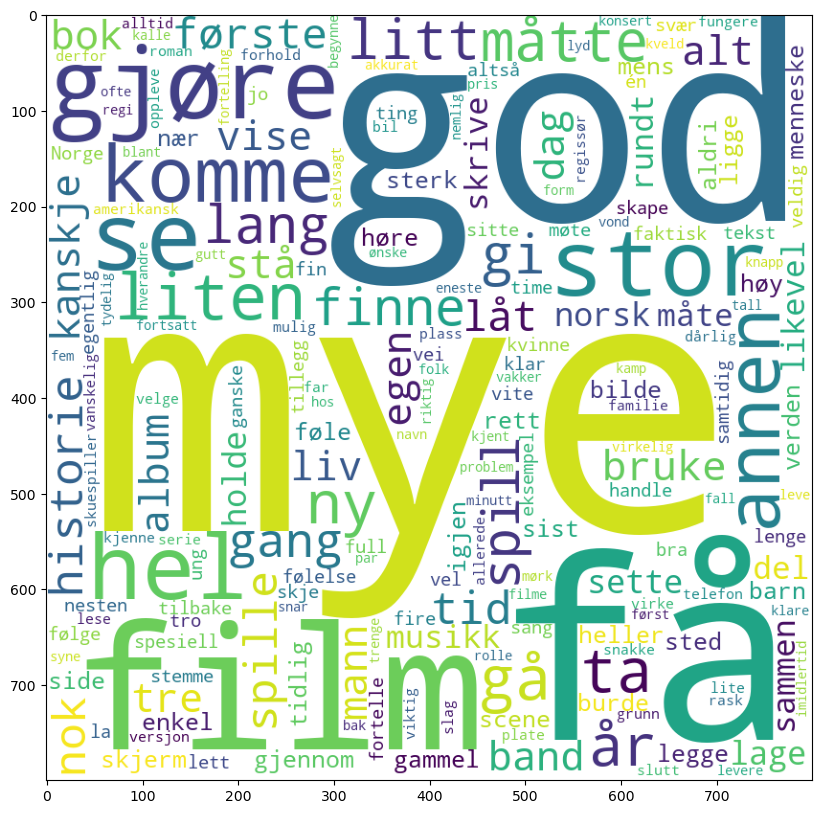

In [8]:
X_train_wc = []

for i in X_train_lemmas:
    for k in i.split():
        if k not in stops:
            X_train_wc.append(k)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate((' '.join(X_train_wc)))

# print(X_train_wc)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.tight_layout(pad = 0)

plt.show()

In [9]:
X_test = vectorizer.transform(X_test_lemmas).toarray()

X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Section for calculating accuracy and elaborating on reasons why the accuracy is poor

In [10]:
classifier = SGDClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [11]:
print(f'Non-rescaled: {accuracy_score(y_test, y_pred)}')

Non-rescaled: 0.6274343776460627


In [12]:
print(confusion_matrix(y_test, y_pred))

[[ 41  80  61]
 [ 33 449 116]
 [ 28 122 251]]


In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.40      0.23      0.29       182
     Neutral       0.69      0.75      0.72       598
    Positive       0.59      0.63      0.61       401

    accuracy                           0.63      1181
   macro avg       0.56      0.53      0.54      1181
weighted avg       0.61      0.63      0.61      1181



In [14]:
resampler = BorderlineSMOTE(random_state=123)

X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)

In [15]:
y_train_res.value_counts()

Neutral     4079
Negative    4079
Positive    4079
Name: label, dtype: int64

In [16]:
classifier_res = SGDClassifier()
classifier_res.fit(X_train_res, y_train_res)
y_pred_res = classifier_res.predict(X_test)

In [17]:
print(f'Rescaled: {accuracy_score(y_test, y_pred_res)}')

Rescaled: 0.6164267569856055


In [18]:
print(confusion_matrix(y_test, y_pred_res))

[[ 33  76  73]
 [ 41 434 123]
 [ 22 118 261]]


In [19]:
print(classification_report(y_test, y_pred_res))

              precision    recall  f1-score   support

    Negative       0.34      0.18      0.24       182
     Neutral       0.69      0.73      0.71       598
    Positive       0.57      0.65      0.61       401

    accuracy                           0.62      1181
   macro avg       0.54      0.52      0.52      1181
weighted avg       0.60      0.62      0.60      1181

